<a href="https://colab.research.google.com/github/gxflove307/R-CNN_object_detection/blob/main/R_CNN_Implement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os,cv2,keras,csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import random

#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()

In [ ]:
!pip install pyprind
import pyprind

In [ ]:
PathImg = '/content/drive/My Drive/My MCM Practicum/Insight-MVT_Annotation_Test_part/' #图片目录
PathCsv ='/content/drive/My Drive/XML/CSV/'#注释目录
PathTest ='/content/drive/My Drive/My MCM Practicum/Prediction/'#预测目录
PathSave ='/content/drive/My Drive/My MCM Practicum/Prediction_pict/'#保存目录

In [ ]:
 #python画图保存 以左上角为原点
 #a = random.randint(0,60)
 for e,i in enumerate(os.listdir(PathTest)):
    #if e ==a:      
      filename = i.split(".")[0]+".jpg"
      # print(a)
      #print(filename)
      img = cv2.imread(os.path.join(PathImg,filename))
      #print(img.shape)
      df = pd.read_csv(os.path.join(PathTest,i),sep=',')
      df.reset_index(inplace=True)
      #plt.imshow(img)
      gtvalues=[]
      #print(df)
      for index,row in df.iterrows():
          x1 = int(row[0])
          y1 = int(row[1])
          x2 = int(row[2])
          y2 = int(row[3])
          gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
          cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0), 2)
      plt.figure()
      plt.imshow(img)
      plt.savefig(os.path.join(PathSave,filename))
      

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


17
MVI_20012-img00745.jpg
   level_0  level_1    4  745
0      348       49  497  327
1      658      246  790  370
2      659       10  693   33
3      464       18  494   44


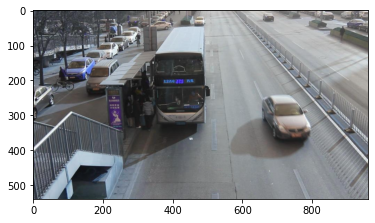

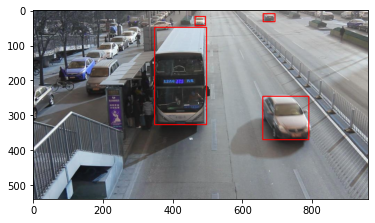

In [ ]:
 #python画图 以左上角为原点
 a = random.randint(0,60)
 for e,i in enumerate(os.listdir(PathCsv)):
      #if e ==a:
      if i=='MVI_20012-img00745.csv':
        filename = i.split(".")[0]+".jpg"
        print(a)
        print(filename)
        img = cv2.imread(os.path.join(PathImg,filename))
        #print(img.shape)
        df = pd.read_csv(os.path.join(PathCsv,i),sep=',')
        df.reset_index(inplace=True)
        plt.imshow(img)
        gtvalues=[]
        print(df)
        for index,row in df.iterrows():
            x1 = int(row[0])
            y1 = int(row[1])
            x2 = int(row[2])
            y2 = int(row[3])
            gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
            cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0), 2)
        plt.figure()
        plt.imshow(img)
        #plt.savefig(os.path.join(PathSave,filename))
        break

选择性搜索是区域规划算法的方法，被用于目标检测。它具有fast 和 high recall 的特性。算法原理：基于颜色、纹理、大小和形状等，将image分层划分为诸多相似区域。

In [ ]:
cv2.setUseOptimized(True);#打开优化代码
# create Selective Search Segmentation Object using default parameters 使用默认参数创建选择性搜索分割对象
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [ ]:
#剔除候选框中面积小于2000px，长宽比大于2的box
def get_usefulbox(bb):
  bb=pd.DataFrame(bb,columns=['x','y','w','h'])
  bb.drop(bb[(bb.w * bb.h < 2000) | (bb.w/bb.h > 2) | (bb.h/bb.w > 2)].index,inplace=True)
  bb.reset_index()
  bb = bb.values
  return bb

In [ ]:
%%time
im = cv2.imread(os.path.join(PathImg,filename))
ss.setBaseImage(im)#set input image on which we will run segmentation  设置我们将运行分割的输入图像，
ss.switchToSelectiveSearchQuality()#fast but low recall Selective Search method 选择速度快的分隔方法  还可以使用SearchQuality()基于质量不过运行慢
rects = ss.process()#run selective search segmentation on input image 处理图片
rects = get_usefulbox(rects)
imOut = im.copy()# create a copy of original image 创建一个原图片的备份
for i, rect in (enumerate(rects)):# itereate over all the region proposals 迭代显示所有区域
   if i < 10: #看20个框框就够了
    x, y, w, h = rect
    cv2.rectangle(imOut, (x, y), (x+w, y+h), (255, 0, 0), 2, cv2.LINE_AA)
# plt.figure()
plt.imshow(imOut)

In [ ]:
train_images=[]
train_labels=[]

In [ ]:
#iou(Intersection over union)交并比 可用来验证算法画框的准确性（此处用来确定区域选择的生成框是否可取 iou越大说明属性区域选择生成框与备注框重合部分越大 则可取为训练集）
def get_iou(bb1, bb2): #bb1原图片的备注框 bb2选择搜索生成框
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)#取两个框的重叠部分的面积

    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])#原图备注框面积
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])#选择搜索生成框

    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)#两框重叠部分占两框总面积的比例
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [ ]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()# create Selective Search Segmentation Object using default parameters

In [ ]:
#pbar1 = pyprind.ProgBar(len(os.listdir(PathCsv)),title='Trainset generation')
%%time
for e,i in enumerate(os.listdir(PathCsv)):
    try:
        if e == 0:#选择图片数量
            filename = i.split(".")[0]+".jpg"
            print(e,filename)
            image = cv2.imread(os.path.join(PathImg,filename))
            df = pd.read_csv(os.path.join(PathCsv,i))
            df.reset_index(inplace=True)
            gtvalues=[]
            for index,row in df.iterrows():
              x1 = int(row[0])
              y1 = int(row[1])
              x2 = int(row[2])
              y2 = int(row[3])
              gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
              
            ss.setBaseImage(image)#set input image on which we will run segmentation
            ss.switchToSelectiveSearchFast()#fast but low recall Selective Search method
            ssresults = ss.process()#run selective search segmentation on input image
            ssresults = get_usefulbox(ssresults)
            imout = image.copy()# create a copy of original image 
            #pbar1.update()
            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0
            #pbar2 = pyprind.ProgBar(len(ssresults),title='ssresults images')
            for e,result in enumerate(ssresults):
                #pbar2.update()
                if e < 2000 and flag == 0:
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        if counter < 30:
                            if iou > 0.7:#重合面积大于70%
                                timage = imout[y:y+h,x:x+w]#合并图片
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)#将选择划分的图片中与原备注框重合率大于70%的作为训练集并添加标签为1
                                train_labels.append(1)
                                counter += 1
                                #print("counter=%d" %counter)
                        else :
                            fflag =1
                        if falsecounter <30:
                            if iou < 0.3:
                                timage = imout[y:y+h,x:x+w]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                train_images.append(resized)#将选择划分的图片中与原备注框重合率小于30%的作为训练集并添加标签为0
                                train_labels.append(0)
                                falsecounter += 1
                                #print("falsecounter=%d" %falsecounter)
                        else :
                            bflag = 1
                    if fflag == 1 and bflag == 1:
                        print("inside")
                        flag = 1
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

1 MVI_39371_img00668.jpg
CPU times: user 11.3 s, sys: 84.2 ms, total: 11.4 s
Wall time: 9.95 s


In [ ]:
X_new = np.array(train_images)
y_new = np.array(train_labels)

In [ ]:
np.save("/content/drive/My Drive/XML/550_X_new.npy",np.array(train_images))


In [ ]:
np.save("/content/drive/My Drive/XML/550_y_new.npy",np.array(train_labels))

In [ ]:
X_new = np.load("/content/drive/My Drive/My MCM Practicum/400_X_new.npy")
y_new = np.load("/content/drive/My Drive/My MCM Practicum/400_y_new.npy")

In [ ]:
print(X_new.shape)
print(y_new.shape)


(21059, 224, 224, 3)
(21059,)


In [ ]:
from keras.layers import Dense
from keras import Model
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16


In [ ]:
#transfer learning 
vggmodel = VGG16(weights='imagenet', include_top=True)
#vggmodel.summary()

In [ ]:
#freezing the first 15 layers of the model 冻结模型的前19层
for layers in (vggmodel.layers)[:15]:
    print(layers)
    layers.trainable = False

In [ ]:
#取模型的最后2层
X= vggmodel.layers[-2].output

In [ ]:
#adding a 2 unit softmax dense layer as we have just 2 classes to predict 添加两个softmax层 分类为2
predictions = Dense(2, activation="softmax")(X)

In [ ]:
model_final = Model(input = vggmodel.input, output = predictions)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  """Entry point for launching an IPython kernel.


In [ ]:

from keras.optimizers import Adam
opt = Adam(lr=0.0001)

In [ ]:
model_final.compile(loss = tf.keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])

In [ ]:
#模型创建完毕
model_final.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [ ]:
#one-hot encode
class MyLabelBinarizer(LabelBinarizer):
    def transform(self, y):
        Y = super().transform(y)
        if self.y_type_ == 'binary':
            return np.hstack((Y, 1-Y))
        else:
            return Y
    def inverse_transform(self, Y, threshold=None):
        if self.y_type_ == 'binary':
            return super().inverse_transform(Y[:, 0], threshold)
        else:
            return super().inverse_transform(Y, threshold)

In [ ]:
lenc = MyLabelBinarizer()
Y =  lenc.fit_transform(y_new)

In [ ]:
#split trin and test set
X_train, X_test , y_train, y_test = train_test_split(X_new,Y,test_size=0.10)

In [ ]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(18953, 224, 224, 3) (2106, 224, 224, 3) (18953, 2) (2106, 2)


In [ ]:
#We will do some augmentation on the dataset like horizontal flip, vertical flip and rotation to increase the dataset. 水平 垂直反转增加数据集
trdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
traindata = trdata.flow(x=X_train, y=y_train)
tsdata = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rotation_range=90)
testdata = tsdata.flow(x=X_test, y=y_test)

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
checkpoint = ModelCheckpoint("rcnn_vgg16_1.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

In [ ]:
%%time
#hist = model_final.fit(x=X_train, y=y_train,batch_size=100, epochs= 1000,validation_data=(X_test,y_test),callbacks=[checkpoint,early])
hist = model_final.fit_generator(generator= traindata, steps_per_epoch= 10, epochs= 1000, validation_data= testdata, validation_steps=2, callbacks=[checkpoint,early])

Epoch 1/1000
10/10 [==============================] - 9s 917ms/step - loss: 1.1447 - accuracy: 0.6562 - val_loss: 0.6555 - val_accuracy: 0.6719

Epoch 00001: val_loss improved from inf to 0.65555, saving model to rcnn_vgg16_1.h5
Epoch 2/1000
10/10 [==============================] - 1s 144ms/step - loss: 0.4557 - accuracy: 0.8094 - val_loss: 0.3031 - val_accuracy: 0.8750

Epoch 00002: val_loss improved from 0.65555 to 0.30312, saving model to rcnn_vgg16_1.h5
Epoch 3/1000
10/10 [==============================] - 2s 173ms/step - loss: 0.3492 - accuracy: 0.8406 - val_loss: 0.2583 - val_accuracy: 0.8281

Epoch 00003: val_loss improved from 0.30312 to 0.25834, saving model to rcnn_vgg16_1.h5
Epoch 4/1000
10/10 [==============================] - 3s 257ms/step - loss: 0.2997 - accuracy: 0.8750 - val_loss: 0.3466 - val_accuracy: 0.9062

Epoch 00004: val_loss did not improve from 0.25834
Epoch 5/1000
10/10 [==============================] - 4s 356ms/step - loss: 0.2445 - accuracy: 0.9094 - val_l

In [ ]:
!/opt/bin/nvidia-smi

Sat Jun 27 12:36:58 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    44W / 250W |   8867MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

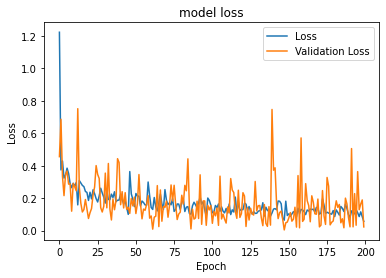

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
# plt.plot(hist.history["acc"])
# plt.plot(hist.history['val_acc'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()
plt.savefig('chart loss.png')

vehicle


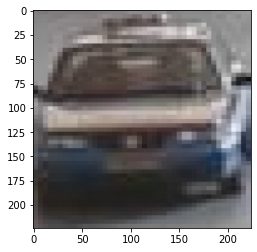

In [ ]:
im = X_test[127]
plt.imshow(im)
img = np.expand_dims(im, axis=0)
out= model_final.predict(img)
if out[0][0] > out[0][1]:
    print("vehicle")
else:
    print("not vehicle")

In [ ]:
model_final.save('/content/drive/My Drive/My MCM Practicum/400_model.h5')

In [ ]:
import os,cv2,keras
from keras.models import load_model

In [ ]:
model_final = load_model("/content/drive/My Drive/My MCM Practicum/400_model.h5")

In [ ]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation() # create Selective Search Segmentation Object using default parameters

MVI_40775_img00205.jpg
132
CPU times: user 16.8 s, sys: 1.38 s, total: 18.1 s
Wall time: 21.3 s


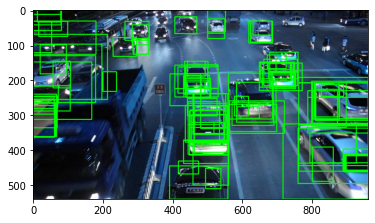

In [ ]:
%%time
z=0
a = random.randint(0,60)
for e,i in enumerate(os.listdir(PathImg)):
    if e == a:
    #if i =='MVI_40761_img00166.jpg':
        print(i)
        #z += 1
        img = cv2.imread(os.path.join(PathImg,i))
        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        ssresults = get_usefulbox(ssresults)
        imout = img.copy()
        for e,result in enumerate(ssresults):
            if e < 2000:
                x,y,w,h = result
                timage = imout[y:y+h,x:x+w]
                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                img = np.expand_dims(resized, axis=0)
                out= model_final.predict(img)
                if out[0][0] > 0.5:
                  cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0),2)
                  z+=1
                #print(out[0][0])
        plt.figure()
        plt.imshow(imout)
print(z)        

In [ ]:
len(os.listdir(PathImg))
#print(PathImg)


2400

In [ ]:
%%time
a = random.randint(0,60)
#pbar = pyprind.ProgBar((2400-len(os.listdir(PathTest))),title='Prediction generation')
Imgfiles = os.listdir(PathImg)
Imgfiles.sort(key=lambda x:int(x[4:8]))
for count,name in enumerate(Imgfiles):       
  try:
   filename = name.split(".")[0]+".csv"
   #if not(os.path.exists(os.path.join(PathTest,filename))): 
   if count == a:
        print(name)
        #z += 1
        #pbar.update(item_id=count)
        
        Annopositions = pd.read_csv(os.path.join(PathCsv,filename),sep=',')
        Annopositions.reset_index(inplace=True)
        Annovalues=[]
        getpositions=[]
        getrightpos=[]
        delects=[]
        for index,row in Annopositions.iterrows():
            x1 = int(row[0])
            y1 = int(row[1])
            x2 = int(row[2])
            y2 = int(row[3])
            Annovalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
        img = cv2.imread(os.path.join(PathImg,name))
        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        ssresults = get_usefulbox(ssresults)
        imout = img.copy()
        for area,result in enumerate(ssresults):
            if area < 2000:
                x,y,w,h = result
                timage = imout[y:y+h,x:x+w]
                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                img = np.expand_dims(resized, axis=0)
                out= model_final.predict(img)
                if out[0][0] > 0.7:
                  getpositions.append({"x1":x,"x2":x+w,"y1":y,"y2":y+h})  #将所得到的框的坐标放入getpositions中               
                  #cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0),

        #去重，如果所得带坐标框与Annotation的iou大于0.5 就保存
        for q in range(len(getpositions)):
          for p in range(len(Annovalues)):
            iou = get_iou(getpositions[q],Annovalues[p])
            if iou > 0.5:
              getrightpos.append(getpositions[q])
            if iou == 0:
              getrightpos.append(getpositions[q])

        #去重，如果所得带坐标框之间iou大于0.2 就删除其中一个框
        for i in range(len(getrightpos)):
          for j in range(i+1,len(getrightpos)):
           iou = get_iou(getrightpos[i],getrightpos[j])
           if iou >0.2:
             delects.append(j)
        delects=list(set(delects))     
        getrightpos = [getrightpos[i] for i in range(len(getrightpos)) if i not in delects]
        #在原图的copy中画框
        #将框保存在CSV中
        frame_num = []
        index = []

        Resident_data = open(PathTest+name[0:-4]+'.csv', 'w')
        csvwriter = csv.writer(Resident_data)
        frame_num.append(len(getrightpos))
        csvwriter.writerow(frame_num)
        frame_num = []
        for getpos in getrightpos:
          index.append(getpos['x1'])
          index.append(getpos['y1'])
          index.append(getpos['x2'])
          index.append(getpos['y2'])
          csvwriter.writerow(index)
          index=[]      
        Resident_data.close()
        
  except Exception as e:
      print(e)
      print("error in "+filename)
      continue
#print(pbar)       

MVI_39031_img00409.jpg
CPU times: user 19.4 s, sys: 1.47 s, total: 20.9 s
Wall time: 23.8 s
